# Customer Sentiment Analysis
by Ethan Huffman

### Business Understanding

Companies receive thousands of tweets every day about their products and brands. Manually reviewing this volume of feedback is inefficient and makes it easy to miss important negative sentiment that could signal product issues, customer dissatisfaction, or emerging brand risks.

The goal of this project is to build a machine learning model that can automatically classify tweet sentiment so stakeholders can quickly prioritize feedback that requires attention. By identifying negative sentiment early, product, marketing, and customer support teams can respond faster to potential issues and make more informed decisions based on public customer feedback.


### Data Understanding

The dataset used in this project comes from CrowdFlower (via data.world) and contains over 9,000 tweets related to brands and products. Each tweet was labeled by human reviewers as expressing positive emotion, negative emotion, no emotion toward a brand or product, or uncertainty.

For this proof of concept, the analysis focuses only on tweets with clear positive or negative sentiment. After filtering, the modeling dataset contains 3,548 tweets, with approximately 84% positive sentiment and 16% negative sentiment. This imbalance is important because negative feedback is more costly for a business to miss.

Tweets are short and informal, which introduces limitations such as sarcasm and lack of context. Additionally, Twitter users may not represent all customers, so results should be interpreted as an indicator of public sentiment rather than a complete measure of customer satisfaction.


### Data Preparation 

During data preparation, the dataset was filtered to include only tweets expressing positive or negative sentiment toward a brand or product. Sentiment labels were converted into a binary format to support supervised learning, and the data was split into training and testing sets while preserving class balance. This process ensured the text data was clean, structured, and ready for effective modeling.

In [17]:
# Import pandas for data manipulation and working with DataFrames
import pandas as pd

# Import numpy for numerical operations and array handling
import numpy as np

# Import joblib for saving and loading trained machine learning models
import joblib

# Import function to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import TF-IDF vectorizer to convert text data into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer

# Import Logistic Regression classifier
from sklearn.linear_model import LogisticRegression

# Import Pipeline utility for chaining preprocessing and modeling steps
from sklearn.pipeline import Pipeline

# Import classification metrics for evaluating model performance
from sklearn.metrics import classification_report, confusion_matrix

# Import helper for visualizing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Import matplotlib for plotting and visualizations
import matplotlib.pyplot as plt


In [18]:
# Load the tweet dataset from a CSV file into a pandas DataFrame
df = pd.read_csv(
    "data/judge-1377884607_tweet_product_company.csv",  # File path to the dataset
    encoding="latin-1"  # Encoding used to correctly read special characters
)

# Display the first few rows of the DataFrame to verify the data loaded correctly
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


This step brings the Twitter data into the project so it can be reviewed and analyzed. It ensures that all tweets and their sentiment labels are available for the model to learn from.


In [19]:
# Display the count of each unique value in the emotion label column,
# including NaN values to understand missing data
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts(dropna=False)


is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

This step shows how many tweets are positive, negative, or unclear. Understanding this balance helps explain why some types of feedback are harder to detect and why certain modeling choices are necessary.


In [20]:
# Filter the original DataFrame to only include rows where the emotion
# is either positive or negative (exclude neutral / no emotion)
df_binary = df[
    df["is_there_an_emotion_directed_at_a_brand_or_product"].isin(
        ["Positive emotion", "Negative emotion"]
    )
].copy()  # Create a copy to avoid SettingWithCopy warnings

# Map emotion labels to a binary sentiment value
# Positive emotion -> 1
# Negative emotion -> 0
df_binary["sentiment"] = df_binary[
    "is_there_an_emotion_directed_at_a_brand_or_product"
].map({
    "Positive emotion": 1,
    "Negative emotion": 0
})

# Display the distribution of the new binary sentiment labels
df_binary["sentiment"].value_counts()


sentiment
1    2978
0     570
Name: count, dtype: int64

This step narrows the analysis to tweets with clearly positive or negative sentiment. This keeps the project focused on feedback that can directly inform business decisions and avoids ambiguity.


In [21]:
# Define the feature set as the tweet text
X = df_binary["tweet_text"]

# Define the target variable as the binary sentiment label
y = df_binary["sentiment"]

# Split the data into training and testing sets
# Stratification ensures the class distribution is preserved
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,     # Use 20% of the data for testing
    random_state=42,   # Set random seed for reproducibility
    stratify=y         # Preserve class balance in train and test sets
)

# Display the proportion of each class in the training data
y_train.value_counts(normalize=True)


sentiment
1    0.839323
0    0.160677
Name: proportion, dtype: float64

This step separates the data into two groups: one for training the model and one for testing it. This allows us to check how well the model performs on new, unseen tweets rather than just the data it learned from.


### Modeling

In the modeling stage, a Logistic Regression classifier was trained using a TF-IDF representation of tweet text to convert unstructured language into numerical features. To address class imbalance and better capture negative customer sentiment, class weighting was applied to ensure the model did not overly favor the majority class. This approach produced a balanced and interpretable model that aligns well with the business objective of identifying customer dissatisfaction.

In [22]:
# Create a baseline machine learning pipeline
# Step 1: Convert text into TF-IDF features
# Step 2: Train a Logistic Regression classifier
baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),  # Text vectorization step
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))  # Classification step
])

# Fit the baseline pipeline on the training data
baseline_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

This step creates an initial version of the model to set a performance baseline. The purpose of this model is not to be perfect, but to establish a starting point so we can understand how well a simple approach performs before making improvements.


In [23]:
# Generate predictions on the test dataset using the baseline model
y_pred = baseline_model.predict(X_test)

# Print classification metrics including precision, recall, f1-score, and support
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.09      0.16       114
           1       0.85      1.00      0.92       596

    accuracy                           0.85       710
   macro avg       0.88      0.54      0.54       710
weighted avg       0.86      0.85      0.80       710



This step evaluates how well the initial model performs. It shows how often the model correctly identifies positive and negative tweets, helping us understand where the model performs well and where it struggles.


In [24]:
# Create a pipeline with class weighting to address class imbalance
# Step 1: Convert text into TF-IDF features
# Step 2: Train a Logistic Regression model with balanced class weights
weighted_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),  # Text vectorization step
    ("logreg", LogisticRegression(
        max_iter=1000,            # Increase iterations to ensure convergence
        random_state=42,          # Set random seed for reproducibility
        class_weight="balanced"   # Adjust weights to handle class imbalance
    ))
])

# Fit the weighted model pipeline on the training data
weighted_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

This step improves the model by placing more emphasis on correctly identifying negative sentiment. Missing negative feedback is more costly for a business, so this adjustment helps the model better capture those important cases.


In [25]:
# Define a helper function to summarize key details about a trained model
def summarize_model(model):
    """
    Summarizes basic information about the trained model
    without affecting predictions or performance.
    """
    # Extract the final estimator (classifier) from the pipeline
    final_estimator = model.steps[-1][1]
    
    # Print the overall model object type (Pipeline)
    print("Pipeline type:", type(model).__name__)
    
    # Print the type of the final estimator (e.g., LogisticRegression)
    print("Final estimator type:", type(final_estimator).__name__)
    
    # Print the number of features learned by the classifier
    print("Number of features:", final_estimator.coef_.shape[1])


In [26]:
# Call the helper function to display summary information about the trained weighted model
summarize_model(weighted_model)


Pipeline type: Pipeline
Final estimator type: LogisticRegression
Number of features: 5150


In [27]:
# Generate predictions on the test dataset using the weighted model
y_pred_weighted = weighted_model.predict(X_test)

# Print classification metrics for the weighted model
print(classification_report(y_test, y_pred_weighted))


              precision    recall  f1-score   support

           0       0.49      0.65      0.56       114
           1       0.93      0.87      0.90       596

    accuracy                           0.83       710
   macro avg       0.71      0.76      0.73       710
weighted avg       0.86      0.83      0.84       710



The weighted Logistic Regression model achieves an overall accuracy of 83% while prioritizing the detection of negative customer sentiment, which is the primary business goal. With a recall of 65% for negative sentiment, the model successfully identifies most customer complaints, reducing the risk of missing important product or service issues. Although precision for negative sentiment is lower, this trade-off is acceptable because reviewing more potential complaints is preferable to overlooking genuine customer dissatisfaction for companies like Apple and Google.

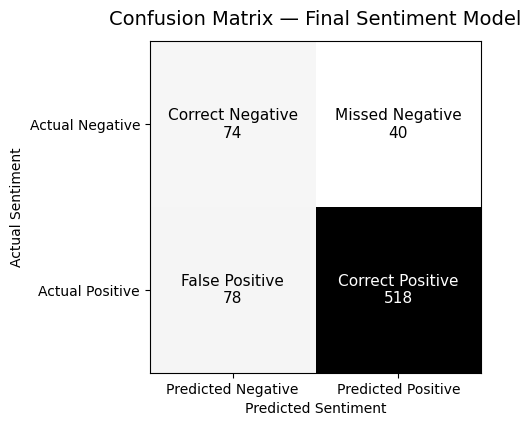

In [28]:
# Assign the weighted model as the final model to be evaluated
final_model = weighted_model

# Generate predictions on the test set using the final model
y_pred = final_model.predict(X_test)

# Compute the confusion matrix comparing actual vs predicted labels
cm = confusion_matrix(y_test, y_pred)

# Create custom labels for each cell in the confusion matrix
labels = np.array([
    ["Correct Negative", "Missed Negative"],
    ["False Positive", "Correct Positive"]
])

# Create a matplotlib figure and axis for the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))

# Display the confusion matrix as a grayscale image
im = ax.imshow(cm, cmap="Greys")

# Set tick positions for both axes
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

# Set tick labels to describe predicted and actual classes
ax.set_xticklabels(["Predicted Negative", "Predicted Positive"])
ax.set_yticklabels(["Actual Negative", "Actual Positive"])

# Define a threshold to determine text color for readability
threshold = cm.max() / 2

# Loop through each cell to add descriptive text and counts
for i in range(2):
    for j in range(2):
        # Choose text color based on background intensity
        color = "white" if cm[i, j] > threshold else "black"
        ax.text(
            j, i,
            f"{labels[i, j]}\n{cm[i, j]}",
            ha="center",
            va="center",
            fontsize=11,
            color=color
        )

# Set the title of the confusion matrix plot
ax.set_title("Confusion Matrix — Final Sentiment Model", fontsize=14, pad=12)

# Label the x-axis and y-axis
ax.set_xlabel("Predicted Sentiment")
ax.set_ylabel("Actual Sentiment")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


This visualization shows where the model makes correct predictions and where it makes mistakes. It provides an intuitive way to understand how often negative or positive tweets are misclassified.


In [29]:
# Get the predicted probabilities for the positive class from the weighted model
proba_pos = weighted_model.predict_proba(X_test)[:, 1]

# Create a DataFrame to analyze prediction results and confidence scores
results = pd.DataFrame({
    "tweet_text": X_test.values,            # Original tweet text
    "true_sentiment": y_test.values,        # Actual sentiment labels
    "predicted_sentiment": y_pred_weighted, # Model-predicted sentiment labels
    "proba_positive": proba_pos              # Probability of positive sentiment
})

# Calculate the probability of negative sentiment
results["proba_negative"] = 1 - results["proba_positive"]

# Display the tweets most likely to be negative according to the model
results.sort_values("proba_negative", ascending=False).head(15)


,tweet_text,true_sentiment,predicted_sentiment,proba_positive,proba_negative
106,I just watched &quot;iPad Design Headaches&quo...,0,0,0.077518,0.922482
153,Barry Diller says that you're silly if you wri...,0,0,0.099390,0.900610
46,#SXSW 2011: Novelty of iPad news apps fades fa...,0,0,0.115140,0.884860
625,ÛÏThe classiest fascist company in existence...,0,0,0.117683,0.882317
528,#SXSW 2011: Novelty of #iPad news apps fades f...,0,0,0.136862,0.863138
667,@mention - #Apple is the classiest fascist com...,0,0,0.144690,0.855310
39,#sxsw is exposing my iphone's horrendous batte...,0,0,0.146032,0.853968
223,ÛÏ@mention Best thing I've heard this weekend...,0,0,0.163102,0.836898
140,RT @mention Best thing I've heard this weekend...,0,0,0.164406,0.835594
421,I've never been surrounded by so many #iPhone ...,1,0,0.164542,0.835458


This step highlights tweets that the model is most confident are negative. This helps stakeholders quickly identify the feedback that may require immediate attention.


In [30]:
# Save the trained weighted model to disk for later use
joblib.dump(weighted_model, "final_sentiment_model.joblib")

# Load the saved model back into memory
loaded_model = joblib.load("final_sentiment_model.joblib")

# Create a Series of new example tweets for sentiment prediction
new_tweets = pd.Series([
    "I love my new iPad, it's amazing!",
    "This phone battery is horrible and keeps dying."
])

# Generate sentiment predictions for the new tweets
preds = loaded_model.predict(new_tweets)

# Generate predicted probabilities for the positive class
proba_pos = loaded_model.predict_proba(new_tweets)[:, 1]

# Display predictions and probability scores in a DataFrame
pd.DataFrame({
    "tweet": new_tweets,              # Original tweet text
    "predicted_sentiment": preds,     # Predicted sentiment label
    "prob_positive": proba_pos,        # Probability of positive sentiment
    "prob_negative": 1 - proba_pos     # Probability of negative sentiment
})


,tweet,predicted_sentiment,prob_positive,prob_negative
0,"I love my new iPad, it's amazing!",1,0.835241,0.164759
1,This phone battery is horrible and keeps dying.,0,0.144157,0.855843


This step demonstrates how the model can be used in practice. New tweets can be entered, and the model returns both a sentiment classification and a confidence score, showing how it could be applied in a real business setting.


In [31]:
joblib.dump(weighted_model, "final_sentiment_model.joblib")

['final_sentiment_model.joblib']

After selecting the best-performing model, the trained model is saved so it can be reused outside
of this notebook. This allows the same model to be loaded into an application and used to make
predictions on new tweets without retraining.

Saving the model ensures consistency between the analysis performed here and the predictions
shown in the deployed application.


### Conclusion

This project demonstrates that an NLP-based sentiment model can effectively classify customer sentiment from Twitter data. By prioritizing the detection of negative sentiment, the final model supports faster identification of potential customer issues.

While the model is not perfect and should not replace human judgment, it provides a scalable way for businesses to monitor public feedback and focus attention where it is most needed. Future improvements could include handling neutral sentiment, expanding to additional platforms, or incorporating sarcasm detection.
